# Import necessary libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import matplotlib.dates as mdates
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, export_text
import warnings
warnings.filterwarnings('ignore')  # Suppress warnings

# Set Matplotlib and Seaborn styles for better visualization
plt.style.use('ggplot')
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

# Load the data

In [3]:
df = pd.read_csv('vendor_aging.csv')

# Prepare data for time series analysis (from previous notebooks)
def prepare_time_series_data(df, snapshot_date_col='Snapshot_Date', vendor_id_col='Vendor ID'):
    """
    Prepare vendor aging data for time series analysis by handling snapshot dates.
    """
    # Create a copy to avoid modifying the original
    result_df = df.copy()

    # Convert snapshot date to datetime if it's not already
    if not pd.api.types.is_datetime64_any_dtype(result_df[snapshot_date_col]):
        result_df[snapshot_date_col] = pd.to_datetime(result_df[snapshot_date_col], errors='coerce')

    # Convert last payment date to datetime if it exists
    if 'LP Date' in result_df.columns and not pd.api.types.is_datetime64_any_dtype(result_df['LP Date']):
        result_df['LP Date'] = pd.to_datetime(result_df['LP Date'], errors='coerce')

    # Sort data by vendor and date
    result_df = result_df.sort_values([vendor_id_col, snapshot_date_col])

    # Add a year-month column for easier grouping
    result_df['Year_Month'] = result_df[snapshot_date_col].dt.to_period('M')

    return result_df

def calculate_aging_metrics_over_time(df, snapshot_date_col='Snapshot_Date',
                                    aging_cols=None, vendor_id_col='Vendor ID'):
    """
    Calculate aging metrics for each vendor across snapshots.
    """
    # Define default aging columns if not specified
    if aging_cols is None:
        aging_cols = [
            'Future_Aging', 'Aging_0_30', 'Aging_31_60', 'Aging_61_90',
            'Aging_91_120', 'Aging_121_180', 'Aging_181_360', 'Above_361_Aging'
        ]

    # Create a copy to avoid modifying the original
    result_df = df.copy()

    # Calculate total aging for each snapshot
    result_df['Total_Aging'] = result_df[aging_cols].sum(axis=1)

    # Calculate aging beyond 90 days
    aging_beyond_90_cols = [col for col in aging_cols if '91' in col or '120' in col or
                           '180' in col or '360' in col or 'Above_361' in col]

    result_df['Aging_Beyond_90'] = result_df[aging_beyond_90_cols].sum(axis=1)

    # Calculate aging percentages
    for col in aging_cols:
        result_df[f'{col}_Pct'] = (result_df[col] / result_df['Total_Aging'].replace(0, np.nan)) * 100
        result_df[f'{col}_Pct'] = result_df[f'{col}_Pct'].fillna(0)

    # Calculate percentage of aging beyond 90 days
    result_df['Pct_Aging_Beyond_90'] = (result_df['Aging_Beyond_90'] /
                                      result_df['Total_Aging'].replace(0, np.nan)) * 100
    result_df['Pct_Aging_Beyond_90'] = result_df['Pct_Aging_Beyond_90'].fillna(0)

    return result_df

def vendor_payment_history_analysis(df, snapshot_date_col='Snapshot_Date', vendor_id_col='Vendor ID',
                                  payment_date_col='LP Date', payment_amount_col='Vendor LP Amount'):
    """
    Analyze vendor payment history across snapshots.
    """
    # Create a copy to avoid modifying the original
    result_df = df.copy()

    # Ensure date columns are datetime
    if not pd.api.types.is_datetime64_any_dtype(result_df[snapshot_date_col]):
        result_df[snapshot_date_col] = pd.to_datetime(result_df[snapshot_date_col], errors='coerce')

    if not pd.api.types.is_datetime64_any_dtype(result_df[payment_date_col]):
        result_df[payment_date_col] = pd.to_datetime(result_df[payment_date_col], errors='coerce')

    # Calculate days between snapshot and last payment
    result_df['Days_Since_Payment'] = (result_df[snapshot_date_col] - result_df[payment_date_col]).dt.days

    # Group by vendor and extract payment history
    payment_history = []

    for vendor_id, group in result_df.groupby(vendor_id_col):
        vendor_history = group.sort_values(snapshot_date_col)

        # Track payment dates and amounts across snapshots
        payment_dates = vendor_history[payment_date_col].dropna().unique()
        payment_dates = sorted(payment_dates)

        # Calculate frequency metrics if we have multiple payments
        if len(payment_dates) >= 2:
            # Calculate average days between payments
            payment_intervals = [(payment_dates[i] - payment_dates[i-1]).days
                               for i in range(1, len(payment_dates))]
            avg_payment_interval = sum(payment_intervals) / len(payment_intervals)

            # Count payments in last 90 days (relative to each snapshot date)
            for idx, row in vendor_history.iterrows():
                snapshot_date = row[snapshot_date_col]
                payments_90d = sum(1 for date in payment_dates
                                  if snapshot_date - timedelta(days=90) <= date <= snapshot_date)

                result_df.loc[idx, 'Payments_Last_90d'] = payments_90d
                result_df.loc[idx, 'Avg_Payment_Interval_Days'] = avg_payment_interval
        else:
            # Only one payment date or none
            vendor_history_indexes = vendor_history.index
            result_df.loc[vendor_history_indexes, 'Payments_Last_90d'] = 0 if len(payment_dates) == 0 else 1
            result_df.loc[vendor_history_indexes, 'Avg_Payment_Interval_Days'] = np.nan

    # Calculate payment regularity score (higher is better)
    # Consider both frequency and consistency
    result_df['Payment_Regularity_Score'] = np.nan

    for vendor_id, group in result_df.groupby(vendor_id_col):
        if 'Avg_Payment_Interval_Days' in group.columns:
            avg_interval = group['Avg_Payment_Interval_Days'].iloc[0]
            if not pd.isna(avg_interval):
                # More regular = lower standard deviation in payment intervals
                # This is a placeholder calculation - in a real implementation,
                # you would use actual payment intervals
                regularity_score = 100 - min(100, avg_interval / 3)  # Higher score for shorter intervals
                result_df.loc[group.index, 'Payment_Regularity_Score'] = regularity_score

    return result_df

# Apply the preliminary functions
prepared_df = prepare_time_series_data(df)
metrics_df = calculate_aging_metrics_over_time(prepared_df)
payment_df = vendor_payment_history_analysis(metrics_df)

print("Data prepared with basic metrics and payment history. Now creating decision support tools...")

Data prepared with basic metrics and payment history. Now creating decision support tools...


# Calculate collection priority score

In [4]:
# This function calculates a collection priority score for each vendor based on multiple factors

def calculate_collection_priority_score(df, snapshot_date_col='Snapshot_Date',
                                      balance_col='Balance Outstanding',
                                      aging_beyond_90_col='Aging_Beyond_90',
                                      days_since_payment_col='Days_Since_Payment',
                                      latest_snapshot_only=True):
    """
    Calculate a collection priority score for each vendor based on multiple factors.

    Args:
        df (pandas.DataFrame): Prepared vendor aging data
        snapshot_date_col (str): Column containing snapshot date
        balance_col (str): Column containing outstanding balance
        aging_beyond_90_col (str): Column containing aging beyond 90 days
        days_since_payment_col (str): Column containing days since last payment
        latest_snapshot_only (bool): Whether to use only the latest snapshot

    Returns:
        pandas.DataFrame: DataFrame with collection priority scores
    """
    # Create a copy to avoid modifying the original
    result_df = df.copy()

    # Ensure we have required columns
    if aging_beyond_90_col not in result_df.columns:
        # Calculate it if needed
        aging_beyond_90_cols = [col for col in result_df.columns
                              if '91' in col or '120' in col or '180' in col or '360' in col or 'Above_361' in col]
        result_df[aging_beyond_90_col] = result_df[aging_beyond_90_cols].sum(axis=1)

    # Use only the latest snapshot if requested
    if latest_snapshot_only:
        # Get the latest snapshot for each vendor
        result_df = result_df.sort_values(snapshot_date_col).groupby('Vendor ID').last().reset_index()

    # Calculate components of the priority score

    # 1. Balance component (higher absolute balance = higher priority)
    result_df['Balance_Component'] = result_df[balance_col].abs() / result_df[balance_col].abs().max()

    # 2. Aging component (higher aging ratio = higher priority)
    with np.errstate(divide='ignore', invalid='ignore'):
        result_df['Aging_Ratio'] = result_df[aging_beyond_90_col] / result_df[balance_col].abs()

    result_df['Aging_Ratio'] = result_df['Aging_Ratio'].fillna(0).clip(0, 1)
    result_df['Aging_Component'] = result_df['Aging_Ratio']

    # 3. Time component (more days since payment = higher priority)
    if days_since_payment_col in result_df.columns:
        # Normalize to 0-1 range
        max_days = max(365, result_df[days_since_payment_col].max())  # Cap at 1 year
        result_df['Time_Component'] = result_df[days_since_payment_col] / max_days
        result_df['Time_Component'] = result_df['Time_Component'].fillna(0.5).clip(0, 1)  # Default if missing
    else:
        result_df['Time_Component'] = 0.5  # Default mid-value if not available

    # 4. Trend component (worsening trend = higher priority)
    if 'Aging_Beyond_90_MoM_Change' in result_df.columns:
        # Convert to 0-1 range where 1 = rapid worsening
        max_change = 100  # Cap at 100% increase
        result_df['Trend_Component'] = (
            result_df['Aging_Beyond_90_MoM_Change'].clip(-max_change, max_change) + max_change
        ) / (2 * max_change)
    else:
        result_df['Trend_Component'] = 0.5  # Default mid-value if not available

    # Calculate the combined score (weighted average)
    result_df['Collection_Priority_Score'] = (
        0.35 * result_df['Balance_Component'] +
        0.30 * result_df['Aging_Component'] +
        0.20 * result_df['Time_Component'] +
        0.15 * result_df['Trend_Component']
    )

    # Scale to 0-100 range
    result_df['Collection_Priority_Score'] = result_df['Collection_Priority_Score'] * 100

    # Assign priority categories
    result_df['Collection_Priority'] = pd.cut(
        result_df['Collection_Priority_Score'],
        bins=[0, 25, 50, 75, 100],
        labels=['Low', 'Medium', 'High', 'Critical']
    )

    return result_df


In [5]:
priority_df = calculate_collection_priority_score(payment_df)

# Display information about collection priorities
print("\nCollection priority results:")
priority_counts = priority_df['Collection_Priority'].value_counts()
print(priority_counts)

# Calculate total balance by priority
balance_by_priority = priority_df.groupby('Collection_Priority')['Balance Outstanding'].sum()
aging_by_priority = priority_df.groupby('Collection_Priority')['Aging_Beyond_90'].sum()


Collection priority results:
Collection_Priority
Medium      121
Low          19
High         10
Critical      0
Name: count, dtype: int64


In [6]:
print("\nBalance and aging by priority:")
for priority in ['Critical', 'High', 'Medium', 'Low']:
    if priority in balance_by_priority:
        print(f"{priority}: ${balance_by_priority[priority]:,.2f} balance, ${aging_by_priority[priority]:,.2f} aging beyond 90")



Balance and aging by priority:
Critical: $0.00 balance, $0.00 aging beyond 90
High: $63,312,768.96 balance, $41,197,182.47 aging beyond 90
Medium: $100,343,814.66 balance, $61,850,310.98 aging beyond 90
Low: $5,493,892.54 balance, $255,348.20 aging beyond 90


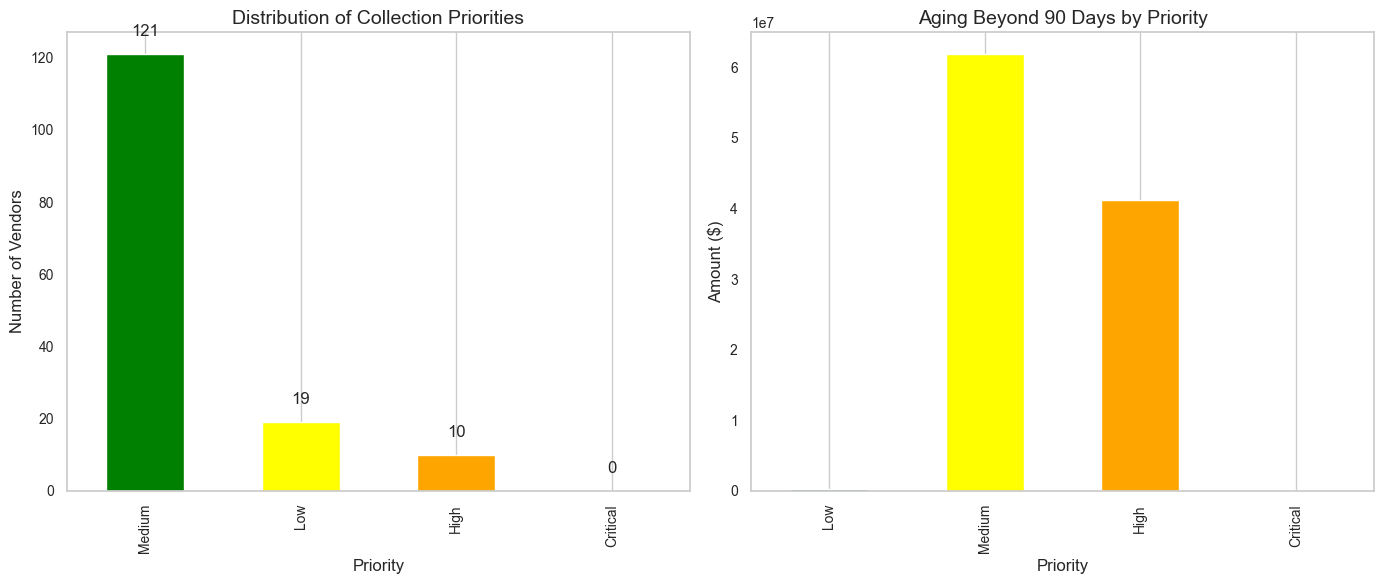

In [7]:
# Visualize priority distribution
plt.figure(figsize=(14, 6))

# Plot 1: Priority counts
plt.subplot(1, 2, 1)
ax = priority_counts.plot(kind='bar', color=['green', 'yellow', 'orange', 'red'])
plt.title('Distribution of Collection Priorities')
plt.xlabel('Priority')
plt.ylabel('Number of Vendors')
plt.grid(axis='y')

# Add count labels on bars
for i, v in enumerate(priority_counts):
    ax.text(i, v + 5, str(v), ha='center')

# Plot 2: Aging by priority
plt.subplot(1, 2, 2)
aging_by_priority.plot(kind='bar', color=['green', 'yellow', 'orange', 'red'])
plt.title('Aging Beyond 90 Days by Priority')
plt.xlabel('Priority')
plt.ylabel('Amount ($)')
plt.grid(axis='y')

plt.tight_layout()
plt.show()

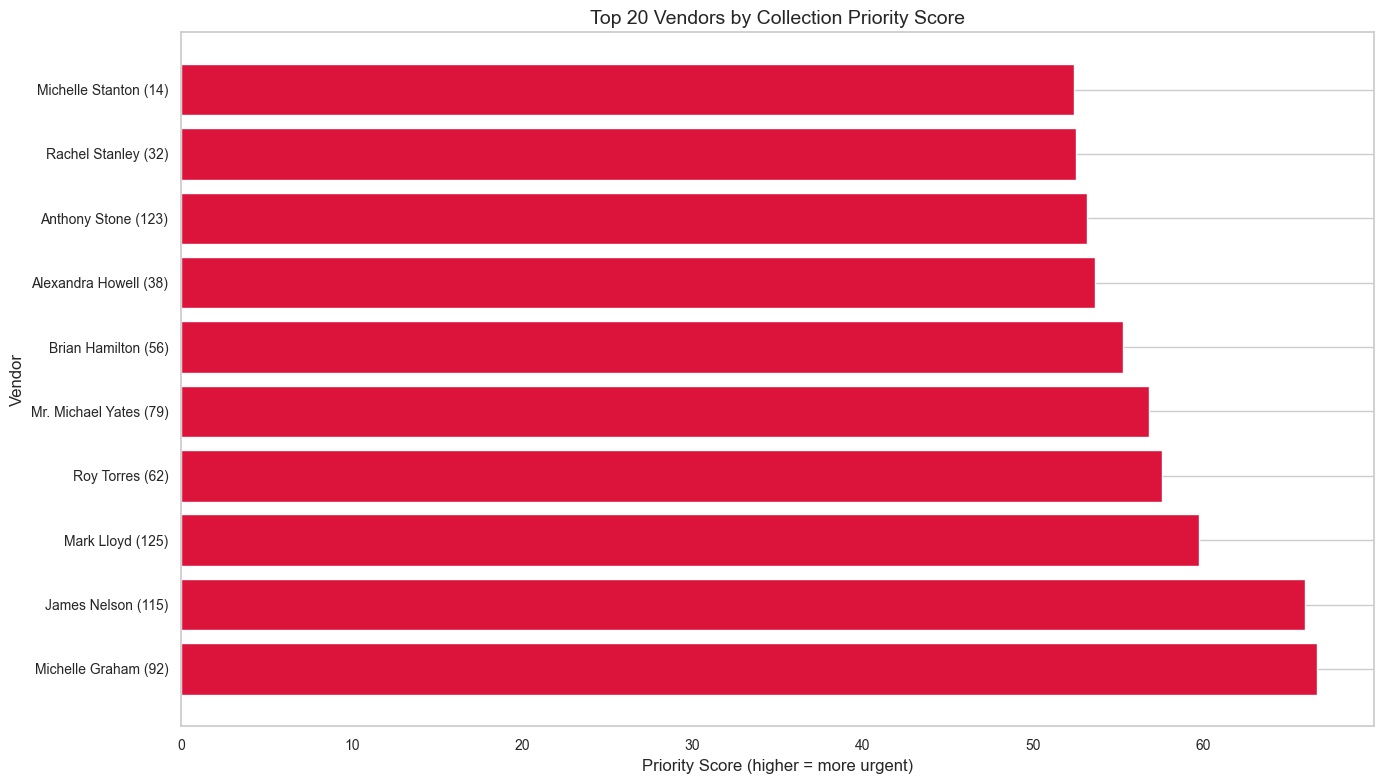

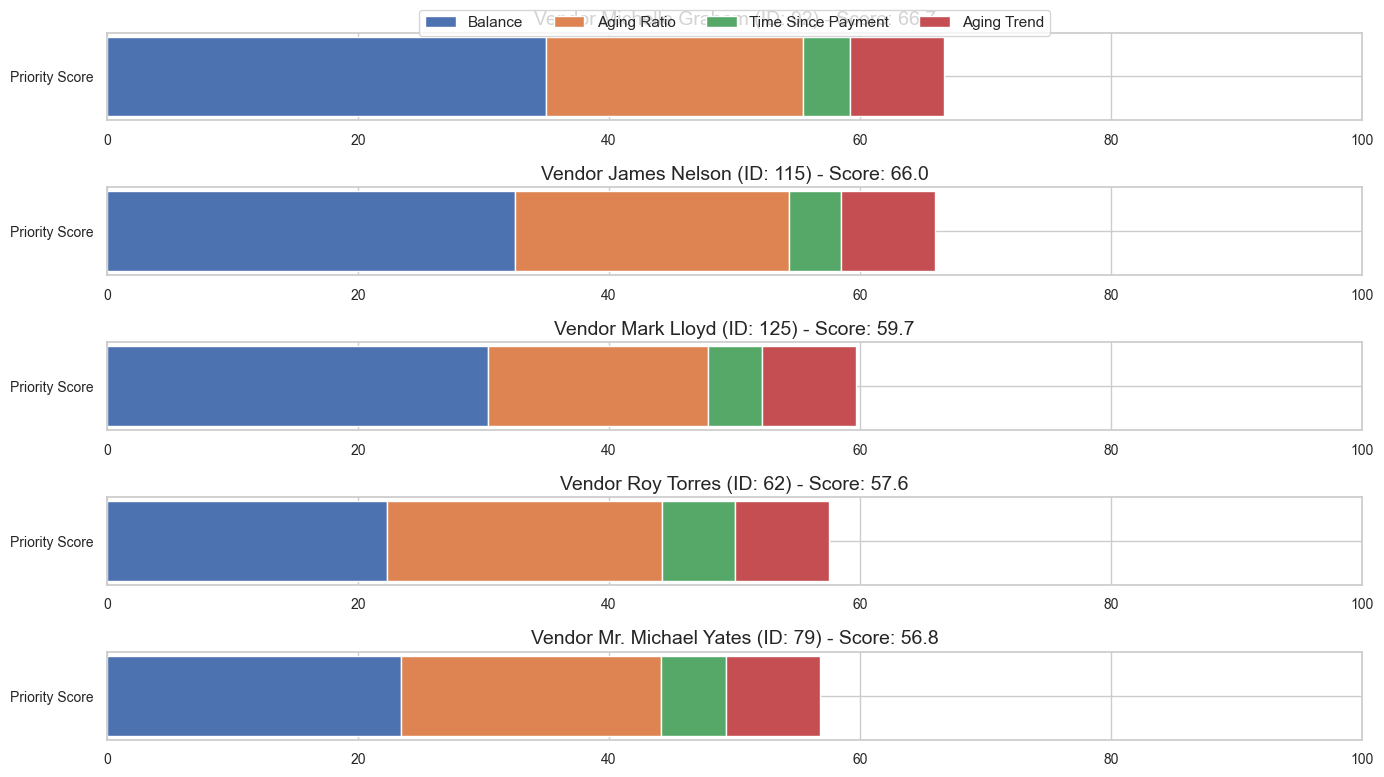

In [9]:
# Visualize top 20 critical vendors
critical_vendors = priority_df[priority_df['Collection_Priority'] == 'High'].sort_values(
    'Collection_Priority_Score', ascending=False
).head(20)

if not critical_vendors.empty:
    plt.figure(figsize=(14, 8))
    plt.barh(
        critical_vendors['Vendor'].astype(str) + ' (' + critical_vendors['Vendor ID'].astype(str) + ')',
        critical_vendors['Collection_Priority_Score'],
        color='crimson'
    )
    plt.title('Top 20 Vendors by Collection Priority Score')
    plt.xlabel('Priority Score (higher = more urgent)')
    plt.ylabel('Vendor')
    plt.grid(axis='x')
    plt.tight_layout()
    plt.show()

    # Show the component breakdown for top 5 critical vendors
    top5_critical = critical_vendors.head(5)
    
    components = ['Balance_Component', 'Aging_Component', 'Time_Component', 'Trend_Component']
    component_weights = [0.35, 0.30, 0.20, 0.15]  # Weights from the function
    component_labels = ['Balance', 'Aging Ratio', 'Time Since Payment', 'Aging Trend']
    
    plt.figure(figsize=(14, 8))
    
    for i, (_, vendor) in enumerate(top5_critical.iterrows()):
        plt.subplot(5, 1, i+1)
        
        # Calculate the weighted components
        weighted_components = [vendor[comp] * weight * 100 for comp, weight in zip(components, component_weights)]
        
        # Create stacked bar
        plt.barh(
            ['Priority Score'], 
            [sum(weighted_components)],
            color='gray',
            alpha=0.3
        )
        
        # Create the component breakdown
        left = 0
        for j, (component, value) in enumerate(zip(component_labels, weighted_components)):
            plt.barh(
                ['Priority Score'], 
                [value],
                left=left,
                label=component
            )
            left += value
        
        plt.title(f"Vendor {vendor['Vendor']} (ID: {vendor['Vendor ID']}) - Score: {vendor['Collection_Priority_Score']:.1f}")
        plt.xlim(0, 100)
        
        # Only show legend for the first subplot
        if i == 0:
            plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35), ncol=4)
    
    plt.tight_layout()
    plt.show()

# Identify Root Causes

In [11]:
# This function identifies root causes of aging issues using decision trees

def identify_root_causes(df, snapshot_date_col='Snapshot_Date',
                       vendor_id_col='Vendor ID',
                       aging_beyond_90_col='Aging_Beyond_90',
                       features=None, min_samples=50):
    """
    Identify root causes of aging issues using decision trees.

    Args:
        df (pandas.DataFrame): Prepared vendor aging data
        snapshot_date_col (str): Column containing snapshot date
        vendor_id_col (str): Column containing vendor identifier
        aging_beyond_90_col (str): Column containing aging beyond 90 days
        features (list): List of features to consider as potential causes
        min_samples (int): Minimum number of samples needed for analysis

    Returns:
        dict: Root cause analysis results
    """
    # Create a copy to avoid modifying the original
    result_df = df.copy()

    # Define default features if not provided
    if features is None:
        features = [
            'country_id', 'SalesPersonID', 'AccountManager_ID',
            'Days_Since_Payment'
        ]

    # Ensure we have the aging column
    if aging_beyond_90_col not in result_df.columns:
        # Calculate it if needed
        aging_beyond_90_cols = [col for col in result_df.columns
                              if '91' in col or '120' in col or '180' in col or '360' in col or 'Above_361' in col]
        result_df[aging_beyond_90_col] = result_df[aging_beyond_90_cols].sum(axis=1)

    # Use only the latest snapshot for each vendor
    latest_df = result_df.sort_values(snapshot_date_col).groupby(vendor_id_col).last().reset_index()

    # Check if we have enough samples
    if len(latest_df) < min_samples:
        return {
            'error': f'Not enough samples for reliable analysis. Need at least {min_samples}, got {len(latest_df)}.'
        }

    # Create the target variable: whether vendor has significant aging issues
    with np.errstate(divide='ignore', invalid='ignore'):
        latest_df['Has_Aging_Issues'] = (
            (latest_df[aging_beyond_90_col] / latest_df['Balance Outstanding'].abs()) > 0.3
        ).astype(int)

    # Prepare features and target
    X = latest_df[features].fillna(-1)  # Replace missing values with -1
    y = latest_df['Has_Aging_Issues']

    # Apply decision tree for root cause analysis
    tree = DecisionTreeClassifier(max_depth=4, min_samples_leaf=max(5, min_samples // 20))
    tree.fit(X, y)

    # Extract feature importance
    importance = {feature: importance for feature, importance in zip(features, tree.feature_importances_)}

    # Get tree rules
    tree_rules = export_text(tree, feature_names=features)

    # Identify key factors from the tree
    key_factors = []
    for feature, importance_score in sorted(importance.items(), key=lambda x: x[1], reverse=True):
        if importance_score > 0.05:  # Only include significant factors
            key_factors.append({
                'factor': feature,
                'importance': importance_score,
                'description': get_factor_description(latest_df, feature, aging_beyond_90_col)
            })

    return {
        'key_factors': key_factors,
        'feature_importance': importance,
        'tree_rules': tree_rules
    }

def get_factor_description(df, factor, aging_col):
    """
    Generate a natural language description of how a factor relates to aging.

    Args:
        df (pandas.DataFrame): Data to analyze
        factor (str): Factor column name
        aging_col (str): Aging column name

    Returns:
        str: Description of the factor's impact
    """
    descriptions = {
        'country_id': "Geographic location",
        'SalesPersonID': "Sales representative",
        'AccountManager_ID': "Account manager",
        'Days_Since_Payment': "Time since last payment"
    }

    # Special case for days since payment
    if factor == 'Days_Since_Payment':
        # Find the threshold where aging significantly increases
        thresholds = [30, 60, 90, 120, 180]
        best_threshold = None
        max_difference = 0

        for threshold in thresholds:
            group1 = df[df[factor] <= threshold][aging_col].mean()
            group2 = df[df[factor] > threshold][aging_col].mean()
            difference = group2 - group1

            if difference > max_difference:
                max_difference = difference
                best_threshold = threshold

        if best_threshold:
            return f"Vendors who haven't paid in over {best_threshold} days have significantly higher aging"

    # Default description
    base_desc = descriptions.get(factor, factor)
    return f"{base_desc} is associated with differing aging patterns"

In [12]:
root_causes = identify_root_causes(priority_df)

# Display root cause analysis results
print("\nRoot cause analysis results:")
if 'error' in root_causes:
    print(f"Error: {root_causes['error']}")
else:
    print("Key factors contributing to aging issues:")
    for i, factor in enumerate(root_causes['key_factors']):
        print(f"{i+1}. {factor['factor']}: {factor['importance']:.4f}")


Root cause analysis results:
Key factors contributing to aging issues:
1. Days_Since_Payment: 0.9880
